# Import libraries

In [1]:
import numpy as np
from scipy.spatial import KDTree
import os
import h5py
import pandas as pd
import xarray as xr
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap
import matplotlib as mpl

# Set file paths

In [2]:
# Load TAHMO station data (CSV format with columns:'precipitation')
tahmo_root_dir = r'C:\Users\c.kwa\Desktop\meteosat_retrieval\data_downloads\TAHMO\TAHMO_export_6704eaa37e81da18c0b7e245'
imerg_root_dir = r'D:\Ghana\IMERG_data\GPM\RS\V07\IMERG\IMERG-FR'

# Set threshold list to analyse

In [3]:
thresholds_list = [0.6, 1.7, 2.7, 5, 8.6, 15]

# Import TAHMO stationsdata

In [50]:
station_name_list = []
station_data_list_TAHMO = []
for station in os.listdir(tahmo_root_dir): 
    if station.endswith('.csv'):
        station_file = os.path.join(tahmo_root_dir, station)
        station_data = pd.read_csv(station_file)
        station_name_list.append(station.split('.')[0])
        station_data_list_TAHMO.append(station_data)

sensors_meta_data_tahmo = station_data_list_TAHMO.pop(0)
stations_meta_data_tahmo = station_data_list_TAHMO.pop(0)
sensors_meta_data_tahmo_name = station_name_list.pop(0)
stations_meta_data_tahmo_name = station_name_list.pop(0)


station_data_tahmo_dict = dict(zip(station_name_list, station_data_list_TAHMO))

#Assuming df is the DataFrame containing the data
for station_name in station_data_tahmo_dict:
    if station_data_tahmo_dict[station_name].shape[1] == 3:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 2])

        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2]], axis = 1)

        # # Result
        # display(station_data_tahmo_dict[station_name].head())

    elif station_data_tahmo_dict[station_name].shape[1] == 4:
        station_data_tahmo_dict[station_name]['precipitation (mm)'] = station_data_tahmo_dict[station_name].iloc[:, 2].combine_first(station_data_tahmo_dict[station_name].iloc[:, 1]).combine_first(station_data_tahmo_dict[station_name].iloc[:, 3])
        # Dropping the old columns (optional)
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].drop(station_data_tahmo_dict[station_name].columns[[1, 2, 3]], axis = 1)


    if 'timestamp' in station_data_tahmo_dict[station_name].columns:
        # Set Timestamp as the index
        station_data_tahmo_dict[station_name]['timestamp'] = pd.to_datetime(station_data_tahmo_dict[station_name]['timestamp'])
        station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].set_index('timestamp')

    # Accumulate over 30 minutes
    station_data_tahmo_dict[station_name] = station_data_tahmo_dict[station_name].resample('30min', label = 'right', closed = 'right').sum(min_count = 2)


# Get IMERG files

In [5]:
# Traverse through all subdirectories and files in the given path
imerg_files_path = []
for root, dirs, files in os.walk(imerg_root_dir):
    for file in files:
        if file.endswith(".HDF5"):
            imerg_files_path.append(os.path.join(root, file))

# Get the longitude latitude grid

In [6]:
# Load the SEVIRI file to get longitude latitude grid
file_name = '3B-HHR.MS.MRG.3IMERG.20200101-S013000-E015959.0090.V07B.HDF5'
file_path = fr'D:\Ghana\IMERG_data\GPM\RS\V07\IMERG\IMERG-FR\2020\01\01\{file_name}'

with h5py.File(file_path, 'r') as imerg_ds:
# imerg_ds = xr.open_dataset(file_path) #, engine = 'netcdf4')

     # List the top-level keys (you already found 'grid')
    print("Top-level keys:", list(imerg_ds.keys()))
    print('Down-level keys:', list(imerg_ds['Grid'].keys()))

    grid_lat = imerg_ds['Grid/lat'][:]
    grid_lon = imerg_ds['Grid/lon'][:]
    #print(grid_lat)
    
    # Access the 'grid' group
    precip = imerg_ds['Grid/precipitation'][:]

    
# Create 2D latitude and longitude grids
grid_lon_2d, grid_lat_2d = np.meshgrid(grid_lon, grid_lat)

grid_lat_2d = np.flipud(grid_lat_2d)

Top-level keys: ['Grid']
Down-level keys: ['Intermediate', 'nv', 'lonv', 'latv', 'time', 'lon', 'lat', 'time_bnds', 'lon_bnds', 'lat_bnds', 'precipitation', 'randomError', 'probabilityLiquidPrecipitation', 'precipitationQualityIndex']


# Define function to find nearest grid to stations

In [7]:
def nearest_grid_to_stations(grid_lat, grid_lon, station_lat, station_lon):
    """
    Map stations to nearest grid cells using KDTree.
    
    Parameters
    ----------
    grid_lat : numpy.ndarray
        Latitudes of grid cells.
    grid_lon : numpy.ndarray
        Longitudes of grid cells.
    station_lat : numpy.ndarray
        Latitudes of stations.
    station_lon : numpy.ndarray
        Longitudes of stations.
    
    Returns
    -------
    indices : numpy.ndarray
        Indices of grid cells nearest to each station.
    """
    grid_points = np.array(list(zip(grid_lat.ravel(), grid_lon.ravel())))
    station_points = np.array(list(zip(station_lat, station_lon)))
    tree = KDTree(grid_points)
    distances, indices = tree.query(station_points)
    return distances, indices

[3029375 2982579 2975378 3040197 3007798 2943005 2993404 3029409 3036599
 3061776 3058171 2849389 2863774 2845791 2935799 2960997 3018611 3018597
 3032997 2960978 2899789 3036598 2860180 2942977 3000583]
[0.04841386 0.06098289 0.05350776 0.02374945 0.04949202 0.04065396
 0.01020002 0.05998361 0.03908497 0.03499296 0.02748189 0.03948778
 0.02544235 0.05422665 0.03377682 0.04918357 0.03522198 0.04444778
 0.02135522 0.0487621  0.06878015 0.04160183 0.0523452  0.00402063
 0.02973725]


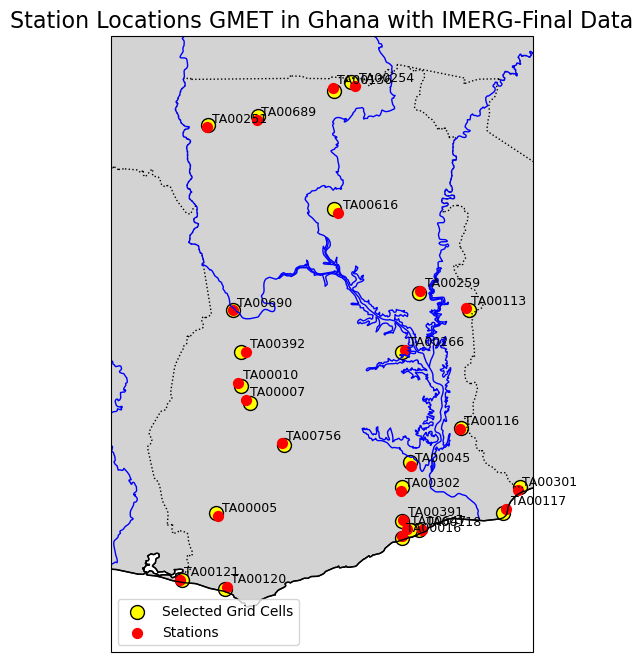

In [8]:
distances, indices = nearest_grid_to_stations(grid_lat_2d, grid_lon_2d, stations_meta_data_tahmo['latitude'], stations_meta_data_tahmo['longitude'])
print(indices)
print(distances)

# # Load the SEVIRI file to get longitude latitude grid
# file_name = '3B-HHR.MS.MRG.3IMERG.20200501-S000000-E002959.0000.V07B.HDF5'
# file_path = fr'D:\Ghana\IMERG_data\GPM\RS\V07\IMERG\IMERG-FR\2020\05\01\{file_name}'

# with h5py.File(file_path, 'r') as imerg_ds:  
#     # Access the 'grid' group
#     precip = imerg_ds['Grid/precipitation'][:]


# Recompute nearest grid cell indices with flipped grid
#indices = nearest_grid_to_stations(grid_lat_2d, grid_lon_2d, stations_meta_data_GMET['LAT'], stations_meta_data_GMET['LON'])

# Create a colormap based on viridis, setting zero values to transparent
viridis = plt.get_cmap('viridis', 256)  # Get the 'viridis' colormap
new_colors = viridis(np.linspace(0, 1, 256))  # Get the RGBA values of the colormap
new_colors[0, -1] = 0  # Set the alpha (transparency) of the first color (zero value) to 0
transparent_viridis = ListedColormap(new_colors)

# Plotting the map
fig = plt.figure(figsize=(14, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Adding features to the map
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
ax.add_feature(cfeature.LAKES, edgecolor='blue', facecolor='none')
ax.add_feature(cfeature.RIVERS, edgecolor='blue')

# Adding the target data using pcolormesh
# pc = ax.pcolormesh(
#     grid_lon_2d, grid_lat_2d, np.ma.masked_where(precip <= -9999 / 2, precip),
#     cmap= transparent_viridis, shading='auto', transform=ccrs.PlateCarree()
# )
# precip_masked = np.ma.masked_where(precip_2d <= -9999, precip_2d)

# Adding a colorbar for the grid data
# cbar = plt.colorbar(pc, ax=ax, orientation='vertical', pad=0.02, label='IMERG-FR (mm/h)')

# Setting map extent to Ghana region
ax.set_extent([-3.7, 1.3, 4.2, 11.5], crs=ccrs.PlateCarree())

# Highlighting the specific grid cells chosen for stations
highlighted_lon = grid_lon_2d.ravel()[indices]
highlighted_lat = grid_lat_2d.ravel()[indices]

ax.scatter(
    highlighted_lon, highlighted_lat, 
    color='yellow', s=100, edgecolor='black', 
    label='Selected Grid Cells', transform=ccrs.PlateCarree()
)


# Plotting station locations
scatter = ax.scatter(
    stations_meta_data_tahmo["longitude"], stations_meta_data_tahmo["latitude"], 
    color='red', s=50, label='Stations', transform=ccrs.PlateCarree()
)

# Adding labels
for i, row in stations_meta_data_tahmo.iterrows():
    ax.text(row["longitude"] + 0.05, row["latitude"] + 0.05, row["station code"], fontsize=9, transform=ccrs.PlateCarree())


# Adding title and legend
plt.title("Station Locations GMET in Ghana with IMERG-Final Data", fontsize=16)
plt.legend(loc='lower left')

# Show the plot after all elements have been added
plt.show()

In [9]:
precip_station_cells = np.zeros(( len(imerg_files_path), len(indices)))
dt_list = np.empty(len(imerg_files_path), dtype = object)

for i, file in enumerate(imerg_files_path):
    try:
        date_str = os.path.basename(file).split('.')[4].split('-')[0]
        time_str = os.path.basename(file).split('.')[4].split('-')[2][1:7]
        dt = datetime.strptime(date_str + time_str, "%Y%m%d%H%M%S") + timedelta(seconds = 1)
        dt_list[i] = dt
        with h5py.File(file, 'r') as f:
            # convert from mm/h to mm/30 min
            precip = f['Grid/precipitation'][:] / 2

                        # # Flip the data along the y-axis
            # target = np.flipud(target)
            # pred = np.flipud(pred)  
    
            # Reducing the time dimension as it is 1
            precip = np.flipud(np.squeeze(precip.T))
    
      
            for j, grid_idx in enumerate(indices):
                precip_station_cells[i, j] = precip.flat[grid_idx]

    except:
        print('Error occured')
        for j, grid_idx in enumerate(indices):
            precip_station_cells[i, j] = np.nan
            

Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error occured
Error 

In [10]:
datetime_index = pd.DatetimeIndex(dt_list)
df_precip = pd.DataFrame(precip_station_cells, index=datetime_index, columns = station_name_list)

df_precip.to_csv(f'imerg_precip_tahmo.csv')
display(df_precip)

,TA00005,TA00007,TA00010,TA00016,TA00045,TA00113,TA00116,TA00117,TA00118,TA00120,...,TA00266,TA00301,TA00302,TA00391,TA00392,TA00616,TA00647,TA00689,TA00690,TA00756
2019-04-01 00:30:00,0.0,0.000,0.0,0.0,0.0,0.085,0.285,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.505,0.0,0.03,0.000,0.0
2019-04-01 00:30:00,0.0,0.000,0.0,0.0,0.0,0.085,0.285,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.505,0.0,0.03,0.000,0.0
2019-04-01 01:00:00,0.0,0.005,0.0,0.0,0.0,0.115,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015,0.600,0.0,0.04,0.015,0.0
2019-04-01 01:00:00,0.0,0.005,0.0,0.0,0.0,0.115,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.015,0.600,0.0,0.04,0.015,0.0
2019-04-01 01:30:00,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.840,0.0,0.00,0.260,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-30 17:00:00,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.00,0.000,0.0
2023-12-30 17:30:00,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.00,0.000,0.0
2023-12-30 18:00:00,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.00,0.000,0.0
2023-12-30 18:30:00,0.0,0.000,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.00,0.000,0.0


In [51]:
df_precip = df_precip[~df_precip.index.duplicated()]
for station_name in station_data_tahmo_dict:   
    df = pd.concat([df_precip[station_name], station_data_tahmo_dict[station_name]], join = 'inner', axis = 1)

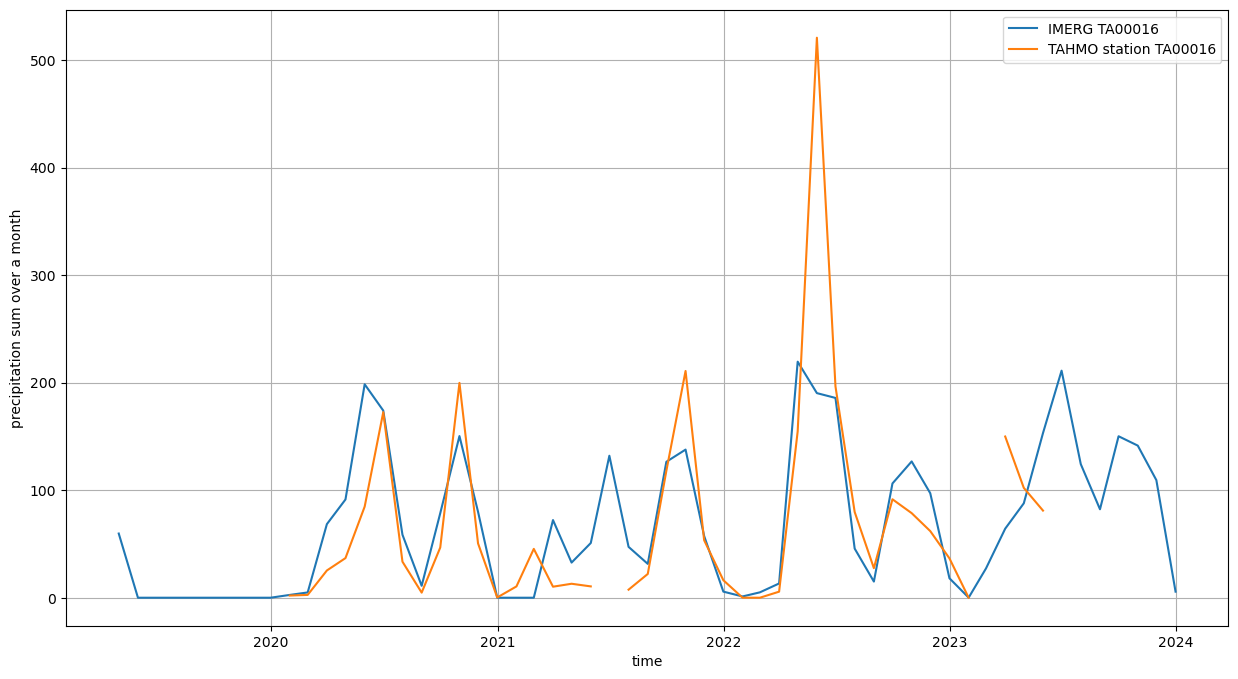

In [53]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'TA00016'

df_gmet = station_data_tahmo_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum(min_count = 1300)

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'TAHMO station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month')
plt.legend()
plt.grid()

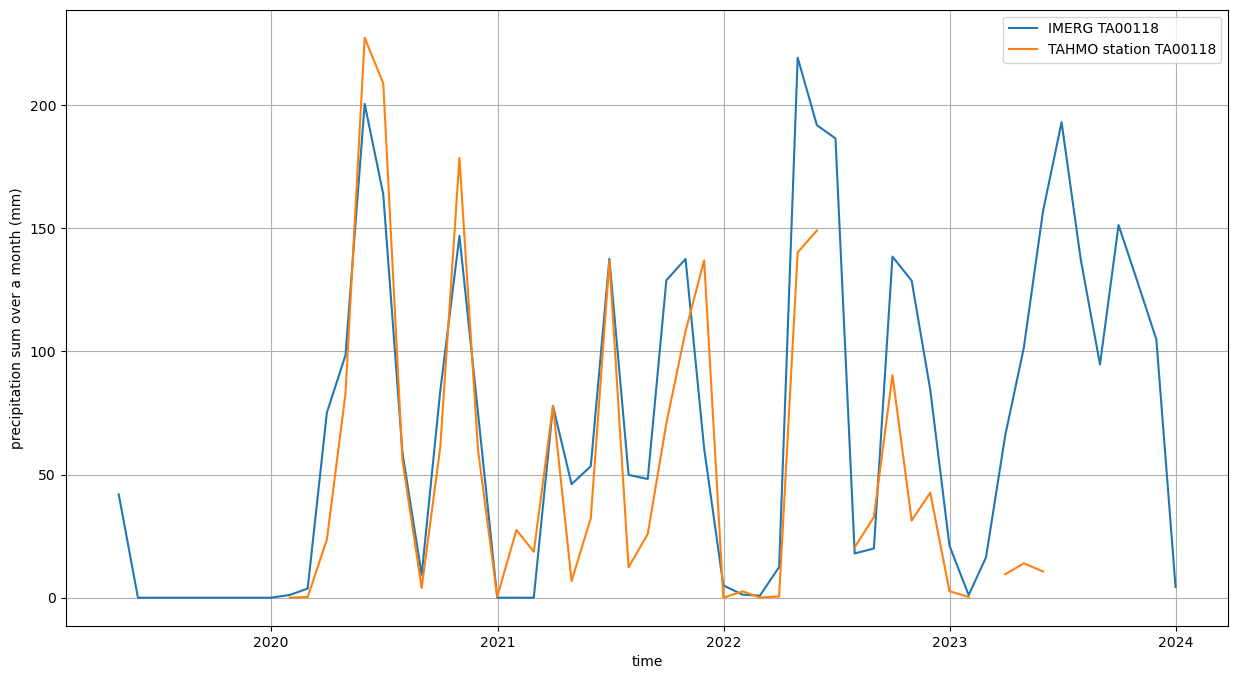

In [57]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'TA00118'

df_gmet = station_data_tahmo_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum(min_count = 1300)

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'TAHMO station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month (mm)')
plt.legend()
plt.grid()

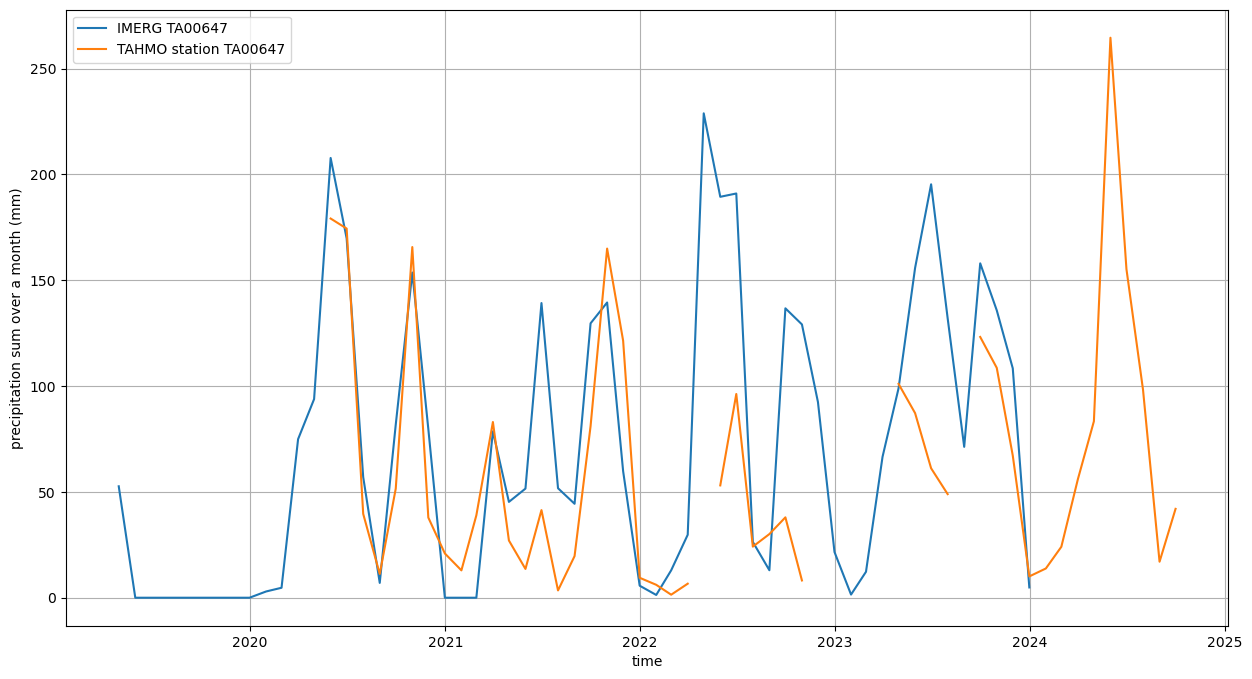

In [58]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'TA00647'

df_gmet = station_data_tahmo_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum(min_count = 1300)

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'TAHMO station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month (mm)')
plt.legend()
plt.grid()

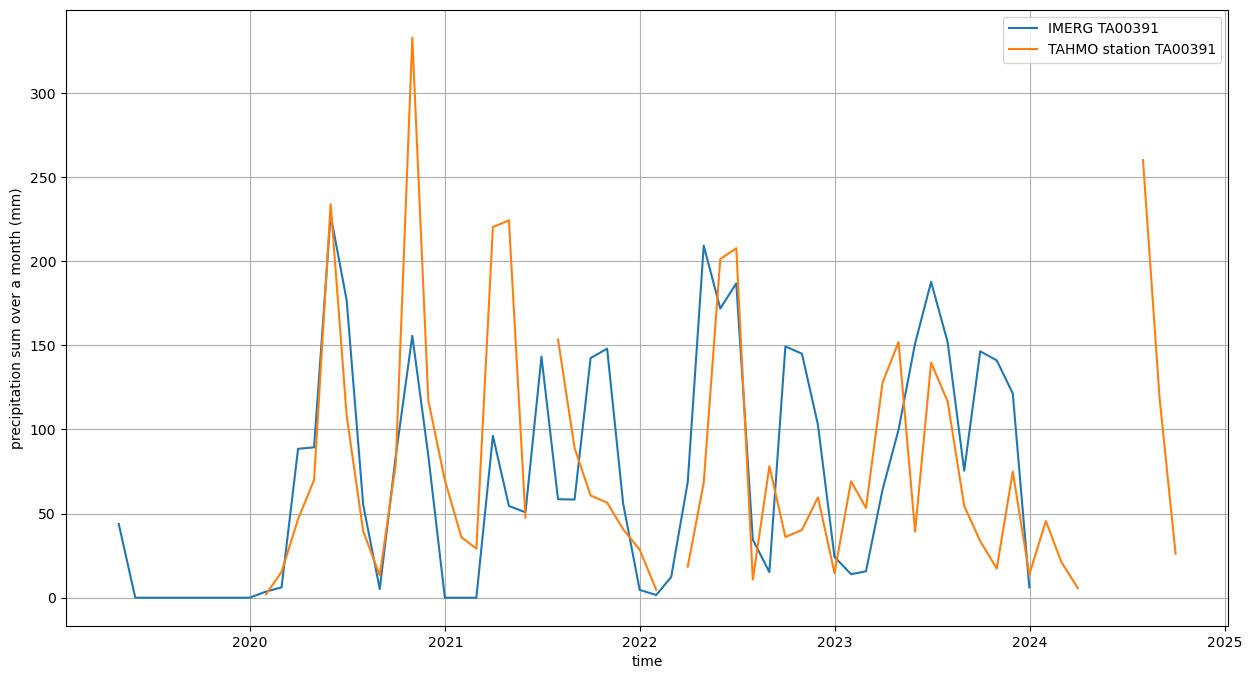

In [59]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'TA00391'

df_gmet = station_data_tahmo_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum(min_count = 1300)

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'TAHMO station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month (mm)')
plt.legend()
plt.grid()

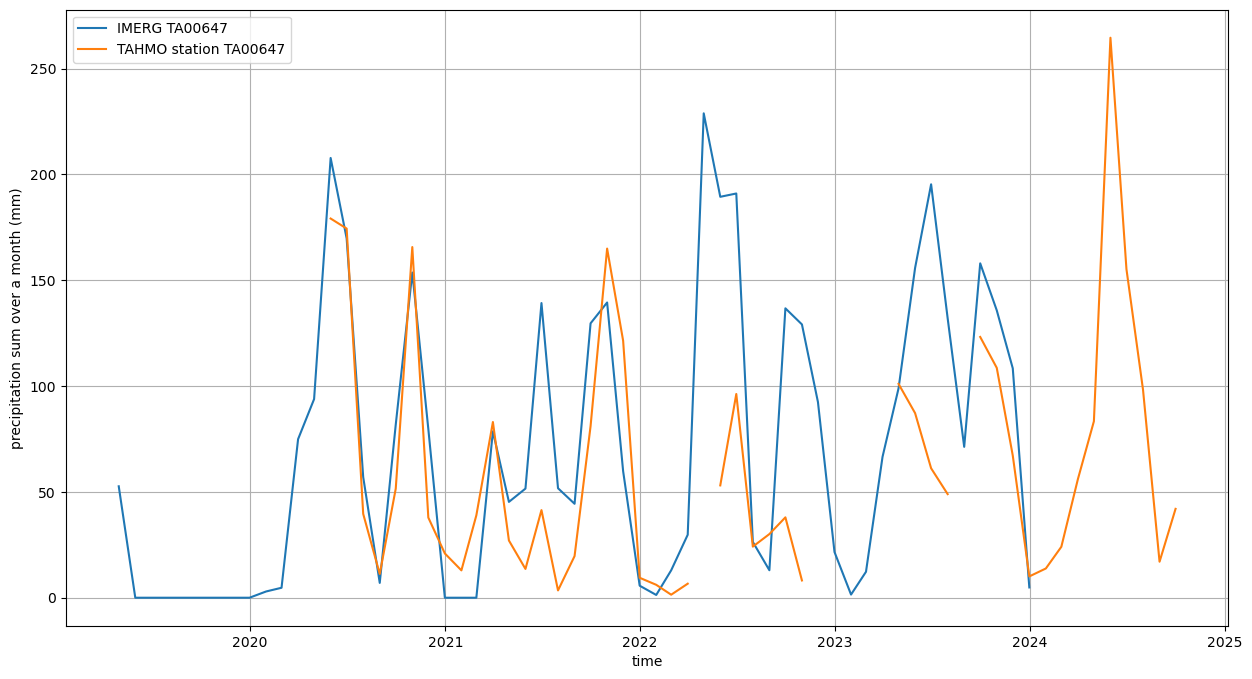

In [61]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'TA00647'

df_gmet = station_data_tahmo_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum(min_count = 1300)

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'TAHMO station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month (mm)')
plt.legend()
plt.grid()

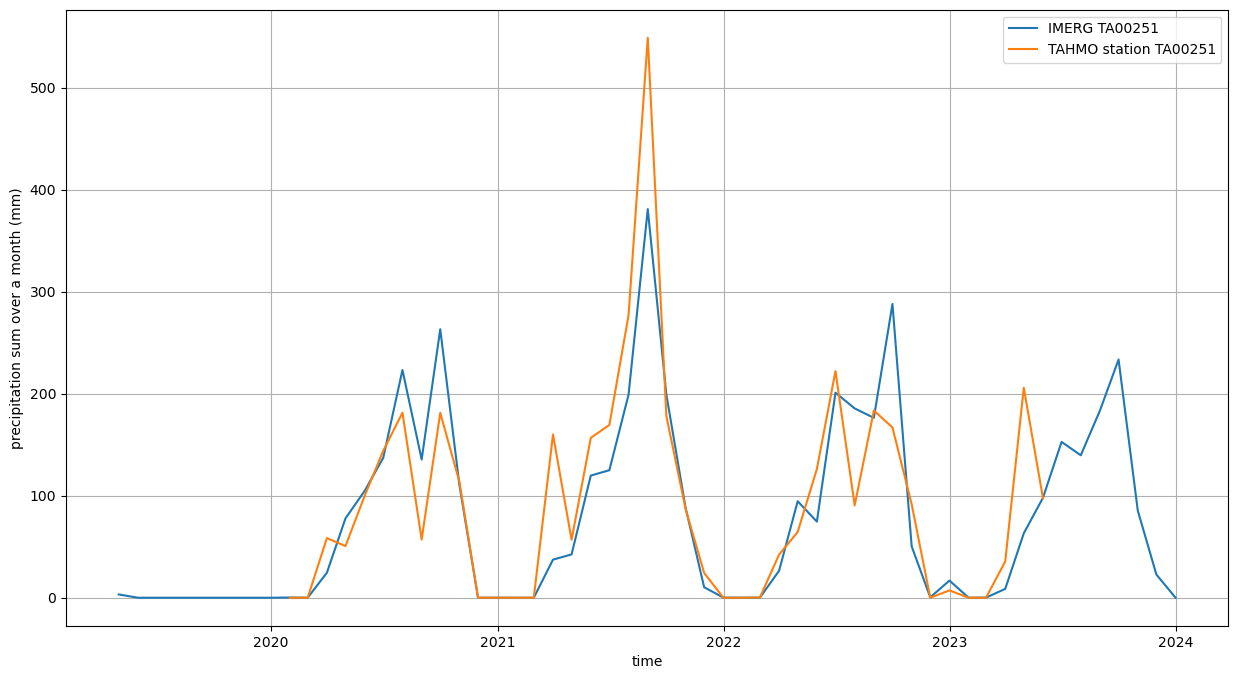

In [64]:
plt.figure(figsize = (15, 8))
df_resampled = df_precip.resample('ME').sum()

station = 'TA00251'

df_gmet = station_data_tahmo_dict[station]
df_gmet = df_gmet.apply(pd.to_numeric, errors='coerce')
df_gmet_resampled = df_gmet.resample('ME').sum(min_count = 1300)

plt.plot(df_resampled[station], label = f'IMERG {station}')
plt.plot(df_gmet_resampled, label = f'TAHMO station {station}')
plt.xlabel('time')
plt.ylabel('precipitation sum over a month (mm)')
plt.legend()
plt.grid()